## Unsupervised Capstone Project

### Ten articles with 10 different authors have been selected for this project. The articles are obtained from free Gutenberg Project and they are all Christmas-related.

In [1]:
import timeit
start=timeit.default_timer()

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from collections import Counter

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import spacy
nlp = spacy.load('en')
from spacy.lang.en.stop_words import STOP_WORDS

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [6]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

## Load files

In [8]:
filename=['brady.txt','butler.txt','cutting.txt','dawson.txt','dyke.txt',
          'hughes.txt','mitchell.txt','richmond.txt','rinehart.txt','stretton.txt']
#filename=['brady.txt','butler.txt']

In [9]:
def load_text(filename):
    file=open(filename,'r')
    text=file.read()
    file.close
    return text

In [10]:
def clean_text(text):
    text=text.lower()
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in text:
       if char not in punctuations:
           no_punct = no_punct + char
    
    no_punct=no_punct.replace("ï»¿"," ")
    no_punct=no_punct.replace("\n"," ")
    
    return no_punct

In [11]:
def sep_text(text):
    text=text.split()
    
    k=30 # Number of sentences
    size=int(len(text)/k)
    para=[None]*k
    j=0
    
    for i in range(0,k):
        para[i]=text[j:j+size]
        para[i]=' '.join(para[i])
        j=j+size
    
    return para

## K-Means Clustering

In [12]:
vectorizer = TfidfVectorizer(stop_words='english',max_features=500)
df = pd.DataFrame()
for i in range(len(filename)):
    text=load_text(filename[i])
    text=clean_text(text)
    text=sep_text(text)
    
    X = vectorizer.fit_transform(text)
    X_np=X.todense()
    X_df=pd.DataFrame(X_np)
    
    #author=filename[i].replace('.txt','')
    #X_df['author']=author   
    X_df['author']=i
    
    df=df.append(X_df)

In [13]:
df.shape

(300, 501)

In [14]:
x=df.drop(['author'],axis=1)
y=df['author']

In [15]:
model = KMeans(n_clusters=10, init='k-means++', n_init=3, max_iter=100)

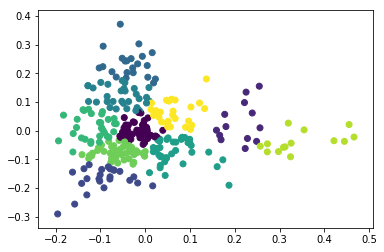

In [16]:
x_norm=normalize(x)
x_pca=PCA(2).fit_transform(x_norm)
y_pred=model.fit_predict(x_pca)
plt.scatter(x_pca[:,0],x_pca[:,1],c=y_pred)
plt.show()

In [17]:
y_pred=model.fit_predict(x_norm)
pd.crosstab(y_pred,y)

author,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,3,1,1,0,2,1,2,5,1,0
1,7,10,2,0,4,2,3,1,1,0
2,4,3,1,8,3,4,2,0,4,1
3,4,0,2,4,3,5,1,6,0,0
4,2,0,4,2,2,3,4,3,1,1
5,1,0,6,2,3,4,11,4,4,17
6,1,0,6,3,8,4,2,4,3,4
7,3,3,3,4,3,2,4,3,2,6
8,2,13,3,1,1,1,0,1,1,0


In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.25,
                                                    random_state=0)

In [19]:
model.fit(x_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=10, n_init=3, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [20]:
from sklearn import metrics
y_pred=model.predict(x_train)
metrics.adjusted_rand_score(y_train, y_pred)

0.03541111562115722

In [21]:
y_pred=model.predict(x_test)    
metrics.adjusted_rand_score(y_test, y_pred)

0.03794893695134948

In [22]:
from sklearn.metrics import pairwise_distances

model.fit(x)
labels=model.labels_

score=metrics.silhouette_score(x, labels, metric='euclidean')
print(score)

0.001767151914388272


## Unsupervised Feature Generation

In [23]:
text_list=[]
for i in range(len(filename)):
    text=load_text(filename[i])
    text=clean_text(text)
    text=sep_text(text)
    text_list=text_list+text

text_list=[]
len_list=[None]*(len(filename)+1)
len_list[0]=0
for i in range(0,len(filename)):
    text=load_text(filename[i])
    text=clean_text(text)
    temp_list=text.split(".")
    len_list[i+1]=len_list[i]+len(temp_list)
    text_list=text_list+temp_list

In [24]:
len(text_list)

300

In [25]:
df.shape

(300, 501)

## Bag of Words

In [26]:
vectorizer=CountVectorizer(stop_words="english", 
                           analyzer='word', 
                           ngram_range=(1, 4), 
                           max_df=1.0, 
                           min_df=1, 
                           max_features=6000)

In [27]:
x = vectorizer.fit_transform(text_list)
x = x.toarray()
x.shape

(300, 6000)

In [28]:
y=df['author']

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.25,
                                                    )

In [30]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(x_train, y_train)
print('Training set score:', rfc.score(x_train, y_train))
print('\nTest set score:', rfc.score(x_test, y_test))

Training set score: 1.0

Test set score: 0.7466666666666667


In [31]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
print('Training set score:', lr.score(x_train, y_train))
print('\nTest set score:', lr.score(x_test, y_test))

Training set score: 1.0

Test set score: 0.9333333333333333


## TFIDF

In [32]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [33]:
x = vectorizer.fit_transform(text_list)
x = x.toarray()
x.shape

(300, 3240)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.25,
                                                    )

In [35]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(x_train, y_train)
print('Training set score:', rfc.score(x_train, y_train))
print('\nTest set score:', rfc.score(x_test, y_test))

Training set score: 0.9955555555555555

Test set score: 0.76


In [36]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
print('Training set score:', lr.score(x_train, y_train))
print('\nTest set score:', lr.score(x_test, y_test))

Training set score: 1.0

Test set score: 0.96
